# model interpretation using SHAP (shapley values) for both global model interpretation and local instance interpretation

## load model to be explained
This approach does not work out of the box, because although the autoML model is a random forest model, it is of a different python object nature, which is not recognized by the SHAP package.

In [7]:
import pickle
filehandler = open(b"../automl_tutorials/diabetes_hyperopt_automl.model","rb")
hs_model = pickle.load(filehandler) #hyperopt-sklearn model

## Load train and test data

In [3]:
import pandas as pd
df_train = pd.read_csv("../automl_tutorials/diabetes_train.csv")
df_test = pd.read_csv("../automl_tutorials/diabetes_test.csv")

## Let's build a randomforest model using the training data using the hyperopt-sklearn autoML recommended parameters

In [10]:
from sklearn.ensemble import RandomForestRegressor
rf_sk_model = RandomForestRegressor(criterion='absolute_error', max_depth=4,
                      max_features='sqrt', max_leaf_nodes=15,
                      min_impurity_decrease=0.02, min_samples_split=3,
                      n_estimators=2669, n_jobs=1, random_state=0,
                      verbose=False)
rf_sk_model.fit(df_train.iloc[:,0:10], df_train['target'])

RandomForestRegressor(criterion='absolute_error', max_depth=4,
                      max_features='sqrt', max_leaf_nodes=15,
                      min_impurity_decrease=0.02, min_samples_split=3,
                      n_estimators=2669, n_jobs=1, random_state=0,
                      verbose=False)

## Let's save this model

In [11]:
import pickle
filehandler_rf = open(b"diabetes_rf_sk.model","wb")
pickle.dump(rf_sk_model,filehandler_rf)
filehandler_rf.close()

## Local interpreation (of an instance, in this case a patient)

In [29]:
import shap
#explainer_shap = shap.TreeExplainer(rf_sk_model)

example_data = shap.utils.sample(df_train.iloc[:,0:10], 100)
shap_explainer =  shap.Explainer(rf_sk_model, example_data) #KernelExplainer

In [30]:
shap_values = shap_explainer(df_train.iloc[:,0:10] ) # it may appear it stopped at 95%, 
                                                     # but it actually finished

 95%|=================== | 336/353 [00:17<00:00]       

In [25]:
explainer_shap.expected_value

array([148.35045539])

In [27]:
shap_values.shape

(253, 10)

## Global interpretation
Compared with the permutation importance method, we can see that there are a few advantges of using shap:
- have the importance of the variables ranked from top to bottom
- direction of the impact by color (e.g, ltg, bmi and bp all have positive impact on the outcome, while hdl has negative impact on the outcome with bigger values)
- The distribution of the impact

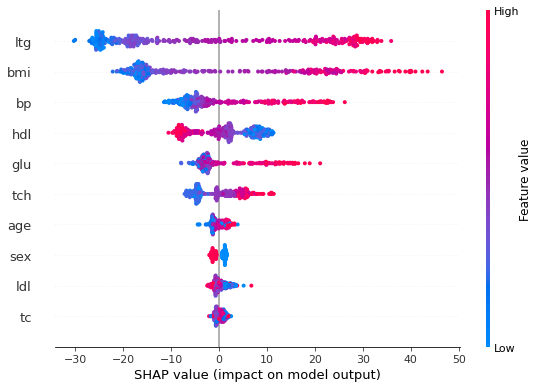

In [31]:
shap.summary_plot(shap_values, df_train.iloc[:,0:10])

### Further examine the global model using heatmap

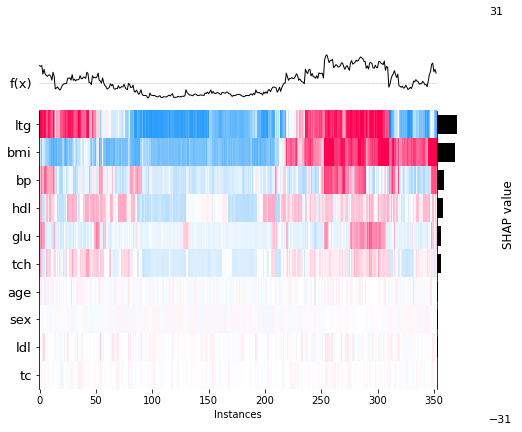

In [35]:
shap.plots.heatmap(shap_values)

### Further examine the global model using heatmap with ordering

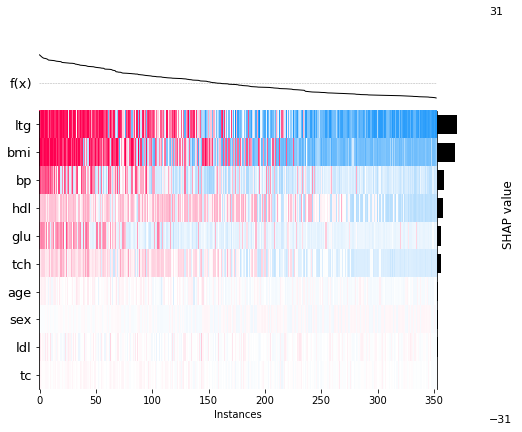

In [36]:
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))

### let's examine the impact of each variable on the outcome individually

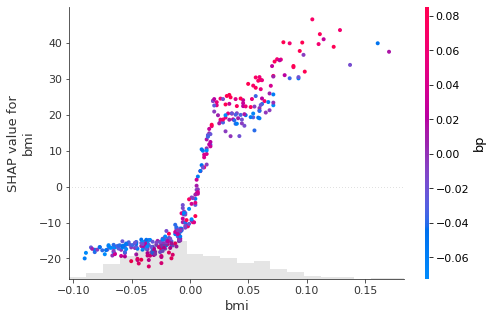

In [38]:
shap.plots.scatter(shap_values[:,"bmi"],color=shap_values)

### the opposite pattern of bmi and hdl is evident here

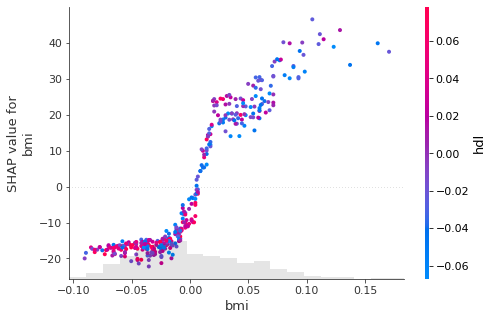

In [39]:
shap.plots.scatter(shap_values[:,"bmi"],color=shap_values[:,"hdl"])

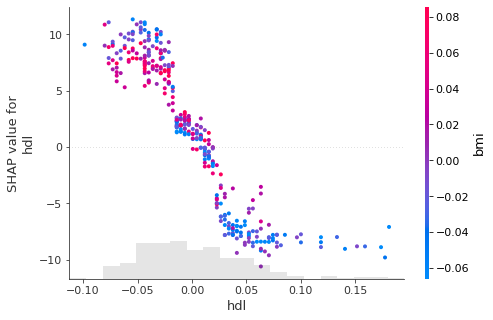

In [40]:
shap.plots.scatter(shap_values[:,"hdl"], color=shap_values) #negative correlation

### the clustering results are not surprising!
- tc, total serum cholesterol
- ldl, low-density lipoproteins
- hdl, high-density lipoproteins
- tch, total cholesterol / HDL
- ltg, possibly log of serum triglycerides level

They are correlated, followed by bmi, the body mass index.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


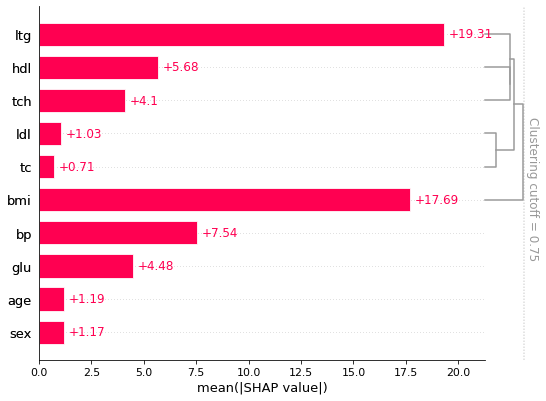

In [42]:
clustering = shap.utils.hclust(df_train.iloc[:,0:10], df_train['target'])
shap.plots.bar(shap_values, clustering=clustering, clustering_cutoff=0.75)

## Local interpretation 
- take a patient, the 101th patient as an example
#patient_for_explain = df_train.iloc[100,0:10].

- Below shows the shapley values for each variable for this particular patient 

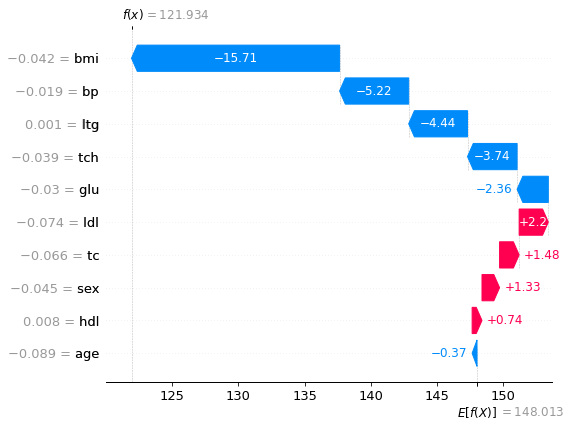

In [33]:
shap.plots.waterfall(shap_values[100])

## We can use interpretation on new data as well (using 50 patients of test data here)

In [43]:
shap_values_new_data = shap_explainer(df_test.iloc[0:50,0:10] )

### plot the shapley values interpretation for the new data
Similar conclusions based on the sample test data, compared to training data

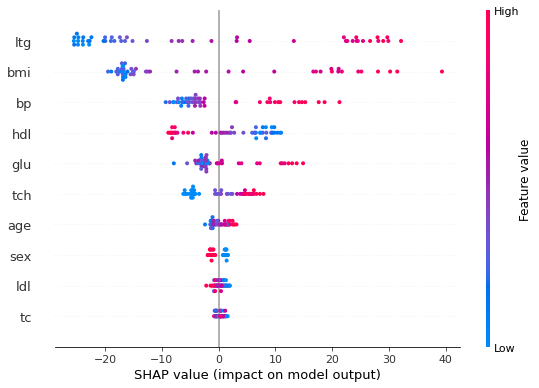

In [45]:
shap.summary_plot(shap_values_new_data, df_test.iloc[0:50,0:10])